In [1]:
%matplotlib inline
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
from fbprophet import Prophet
import pandas as pd
import numpy as np
import pyodbc
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from sklearn.metrics import mean_absolute_error
from datetime import datetime
import matplotlib.legend

import matplotlib.pyplot as plt
import pandas.io.sql as psql

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
cnxn = pyodbc.connect('#####')
cursor = cnxn.cursor()

In [10]:
sql_req_bldg_desc = '''
SELECT CATEGORY_ID, DESCRIPTION
FROM dbo.Building_Class_Categories'''
sql_bldg_desc = pd.read_sql(sql_req_bldg_desc, cnxn)
sql_bldg_desc = sql_bldg_desc.to_dict(orient='dict')

In [11]:
data = cursor.fetchall()
# to fetch the results of a query, but not necessarily put it into a dataframe, use cursor.fetch...
for row in data:
    print row

(-1, -1, u'UNKNOWN')
(1, 1, u'MANHATTAN')
(2, 2, u'BRONX')
(3, 3, u'BROOKLYN')
(4, 4, u'QUEENS')
(5, 5, u'STATEN ISLAND')
(6, 9, u'OUT OF CITY')


In [12]:
# to put results of a query directly in a dataframe, use pandas.read_sql
# arguments are query and conection
# query specifics a specific table by dbo.TABLENAME
pd.read_sql(sql, cnxn)

,BoroughKey,BoroughAltKey,BoroughDescription
0,-1,-1,UNKNOWN
1,1,1,MANHATTAN
2,2,2,BRONX
3,3,3,BROOKLYN
4,4,4,QUEENS
5,5,5,STATEN ISLAND
6,6,9,OUT OF CITY


In [8]:
sql_req_meters_BBL = '''
SELECT Distinct(BBL)
FROM dbo.Fact_Consumption
WHERE Meter_No = '{0}'
'''.format('O75744368')
meter_BBL = pd.read_sql(sql_req_meters_BBL, cnxn)
#meter_BBL['BBL'][0]

In [9]:
sql_req_unique_reads = '''
SELECT COUNT(Distinct ConsumptionCF) FROM dbo.Fact_Consumption
WHERE (ConsumptionDate BETWEEN '2013-03-01 00:00:00' AND '2016-01-01 00:00:00'
AND BBL = '{0}')'''.format(meter_BBL['BBL'][0])
unique_cons = pd.read_sql(sql_req_unique_reads, cnxn)

In [20]:
unique_cons.iloc[0][0]

1380

In [21]:
sql_req_MeterRep = '''
SELECT LMR_Dt, Old_Meter_No, New_Meter_No FROM dbo.MetrsReplaced WHERE
((Old_Meter_No = '{0}' OR New_Meter_No = '{0}')
AND LMR_Dt BETWEEN '2008-01-01 00:00:00' AND '2016-01-01 00:00:00');
'''.format('O75744368')
meter_rep = pd.read_sql(sql_req_MeterRep, cnxn)
meter_rep["LMR_Dt"] = pd.to_datetime(meter_rep["LMR_Dt"])
#meter_rep["LMR_Dt"].dtype

In [22]:
meter_rep["LMR_Dt"]

0   2013-09-18
Name: LMR_Dt, dtype: datetime64[ns]

In [23]:
sql_req_1 = '''
SELECT ConsumptionCF AS y, ConsumptionDate AS ds FROM dbo.Fact_Consumption
WHERE (ConsumptionDate BETWEEN '2013-03-01 00:00:00' AND '2016-01-01 00:00:00'
AND ConsumptionCF <> 0
AND BBL = '{0}')'''.format(meter_BBL['BBL'][0])
cons1 = pd.read_sql(sql_req_1, cnxn)

In [25]:
sql_req_2 = '''
SELECT ConsumptionCF  AS y, ConsumptionDate AS ds FROM dbo.Fact_Consumption
WHERE (ConsumptionDate > '2016-01-01 00:00:00'
AND ConsumptionCF <> 0
AND BBL = '{0}')'''.format(meter_BBL['BBL'][0])
cons2 = pd.read_sql(sql_req_2, cnxn)

In [26]:
cons1["ds"] = pd.to_datetime(cons1["ds"])
cons1["ds"] = (cons1["ds"]).dt.date
cons2["ds"] = pd.to_datetime(cons2["ds"])
cons2["ds"] = (cons2["ds"]).dt.date

In [27]:
cons1a = cons1
cons2a = cons2

In [28]:
cons1a_95 = cons1a.y.quantile(.92)
cons1a_5 = cons1a.y.quantile(.08)
cons1a = cons1a.loc[cons1a['y'] < cons1a_95]
cons1a = cons1a.loc[cons1a['y'] > cons1a_5]

In [29]:
cons2a_95 = cons1a.y.quantile(.95)
cons2a_5 = cons1a.y.quantile(.05)
cons2a = cons2a.loc[cons2a['y'] < cons1a_95]
cons2a = cons2a.loc[cons2a['y'] > cons1a_5]

In [ ]:
N_train = cons1a['Meter_No'].drop_duplicates().count()
N_test = cons2a['Meter_No'].drop_duplicates().count()

In [30]:
fb_cons1 = pd.DataFrame(cons1a.groupby(['ds'])['y'].sum())
fb_cons1['ds'] = fb_cons1.index
fb_cons1 = fb_cons1.reset_index(drop=True)
fb_cons1=fb_cons1.sort_values('ds')
fb_cons1["ds"] = pd.to_datetime(fb_cons1["ds"])
fb_cons2=cons2a[['ds','y']]
fb_cons2 = pd.DataFrame(fb_cons2.groupby(['ds'])['y'].sum())
fb_cons2['ds'] = fb_cons2.index
fb_cons2 = fb_cons2.reset_index(drop=True)
fb_cons2=fb_cons2.sort_values('ds')
fb_cons2["ds"] = pd.to_datetime(fb_cons2["ds"])

In [31]:
if (len(meter_rep) > 0):
    if( meter_rep["LMR_Dt"][0] > fb_cons1[['ds']].min()[0]):
        m = Prophet(yearly_seasonality=True,changepoints=[meter_rep["LMR_Dt"][0]])
    else:
        m = Prophet(yearly_seasonality=True)
else:
    m = Prophet(yearly_seasonality=True)

In [32]:
#m = Prophet(yearly_seasonality=True,changepoints=[X])
m.fit(fb_cons1)
future = m.make_future_dataframe(periods=(fb_cons2.shape[0]+1))

In [33]:
forecast = m.predict(future)
#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

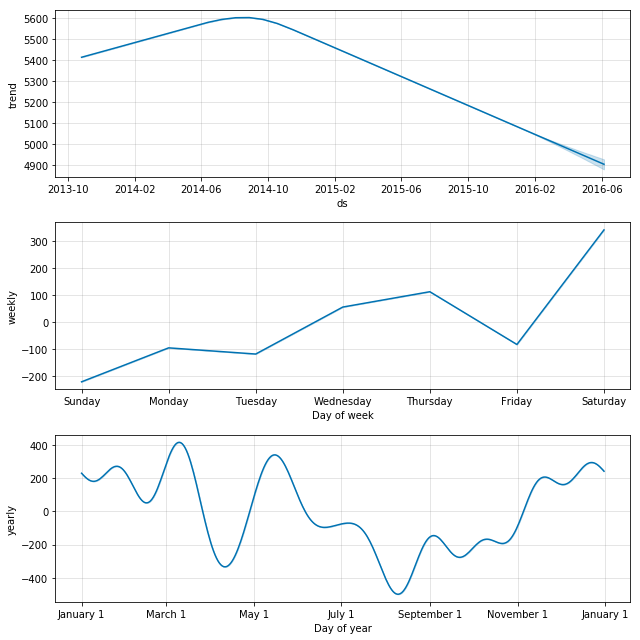

In [34]:
t1=pd.DataFrame({'year': [2016],'month': [1],'day': [1]})
t1 = pd.to_datetime(t1).dt.date

In [37]:
y_16_true = all_2016.loc[all_2016['ds'] >= t1[0], ['y','ds']]
y_16_predict = all_2016.loc[all_2016['ds'] >= t1[0], ['yhat','ds','yhat_lower','yhat_upper']]
y_train_true = all_2016.loc[all_2016['ds'] < t1[0], ['y','ds']]
y_train_predict = all_2016.loc[all_2016['ds'] < t1[0], ['yhat','ds','yhat_lower','yhat_upper']]

In [38]:
mae_test = mean_absolute_error(y_16_true.y, y_16_predict.yhat)
yyhatmean = ((y_16_true['y']+y_16_predict['yhat']).mean())/2
test_mae = ("{:.2%}".format(mae_test/yyhatmean))

In [39]:
mae_train = mean_absolute_error(y_train_true.y, y_train_predict.yhat)
yyhatmean_train = ((y_train_true['y']+y_train_predict['yhat']).mean())/2
train_mae = ("{:.2%}".format(mae_train/yyhatmean_train))

In [40]:
all_2016 = all_2016.sort_values('ds')

In [41]:
yhl_train = y_train_predict.yhat_lower.tolist()
yhu_train = y_train_predict.yhat_upper.tolist()
dates_train = y_train_predict.ds.tolist()
yhl_predict = y_16_predict.yhat_lower.tolist()
yhu_predict = y_16_predict.yhat_upper.tolist()
dates_predict = y_16_predict.ds.tolist()

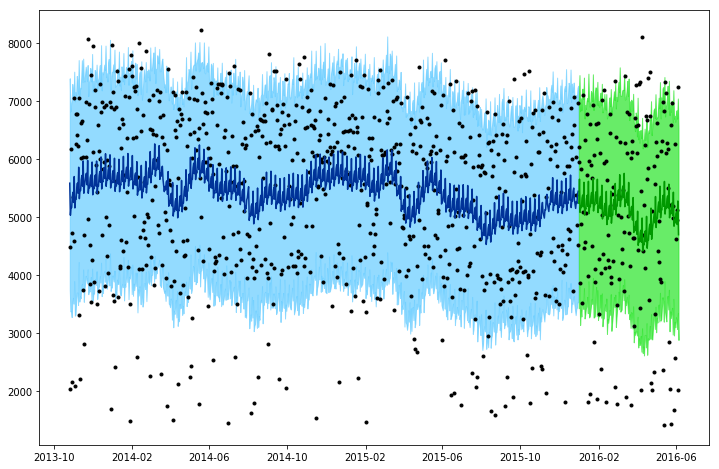

In [42]:
fig = plt.figure(figsize=())

plt.plot(all_2016.ds,all_2016.y,'.k',label='Observed consumption')
plt.plot(y_train_predict.ds,y_train_predict.yhat,color = '#003399',label='Fit cons.')
plt.plot(y_16_predict.ds,y_16_predict.yhat,color = '#009900',label='Forecast cons.')
plt.fill_between(dates_train,yhl_train,yhu_train,color = '#66CCFF', alpha=0.7,label='Fit confidence interval')
plt.fill_between(dates_predict,yhl_predict,yhu_predict,color = '#28E528', alpha = 0.7,label='Forecast confidence interval')

plt.show()

In [21]:
sql_req_bldg_desc = '''
SELECT CATEGORY_ID, DESCRIPTION
FROM dbo.Building_Class_Categories'''
bldg_desc = pd.read_sql(sql_req_bldg_desc, cnxn)
bldg_desc = bldg_desc.to_dict(orient='dict')

In [22]:
bldg_desc

{u'CATEGORY_ID': {0: 1,
  1: 2,
  2: 3,
  3: 4,
  4: 5,
  5: 6,
  6: 7,
  7: 8,
  8: 9,
  9: 10,
  10: 11,
  11: 12,
  12: 13,
  13: 14,
  14: 15,
  15: 16,
  16: 17,
  17: 18,
  18: 19,
  19: 20,
  20: 21,
  21: 22,
  22: 23,
  23: 24,
  24: 25,
  25: 26,
  26: 27,
  27: 28,
  28: 29,
  29: 30,
  30: 31},
 u'DESCRIPTION': {0: u'1-Family                                          ',
  1: u'2-Family                                          ',
  2: u'3-Family                                          ',
  3: u'Multi-Family                                      ',
  4: u'Elevator Apts                                     ',
  5: u'Warehouses                                        ',
  6: u'Factory & Industrial                              ',
  7: u'Garages & Gas Stations                            ',
  8: u'Hotels                                            ',
  9: u'Hospitals & Health                                ',
  10: u'Theaters                                          ',
  11: u'Store B